# **Pairwise Sequence Alignment Demo**

# The Needleman-Wunsch algorithm

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences.
It consists of the following steps:

1. Construct the grid
2. Choose a scoring system (here we use the original scoring system assigning a score $s$ of 1 to a match, a score $s$ of -1 to a mismatch, and a score $d$ of -1 to a gap/indel)
3. Fill in the scoring matrix $F$ (and construct the pointer matrix on the way)
4. Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores in the scoring matrix $F$ are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max
\begin{cases}
    F(i-1,j-1)+s(x_i,y_i),\\
    F(i-1,j)+d,\\
    F(i,j-1)+d.
\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

<img src="nw-matrix.png" width="500" />

We can use the `make_align()` function from our `alignment` module to generate an `align()` function that performs the Needleman-Wunsch algorithm.

In [9]:
import alignment as aln

x = "GATTACA"
y = "CATACCCA"

align = aln.make_align(mode="global")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

We can also plot the alignment together with the scoring matrix:

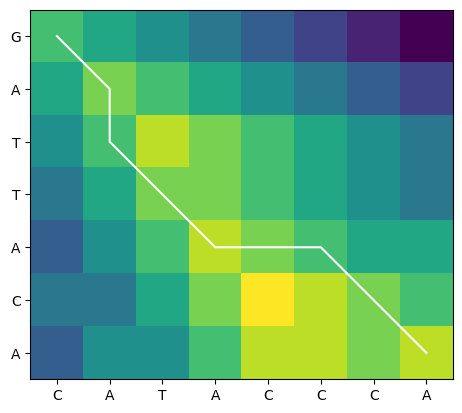

In [10]:
import matplotlib.pyplot as plt

plt.imshow(X=scoring_mat)
plt.plot(warp_path_y, warp_path_x, "w")
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.show()

# The Smith-Waterman algorithm

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences.
It is a variation of the Needleman-Wunsch algorithm.

The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

Again, with our `alignment` module, we can perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`.

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [ 7 17]


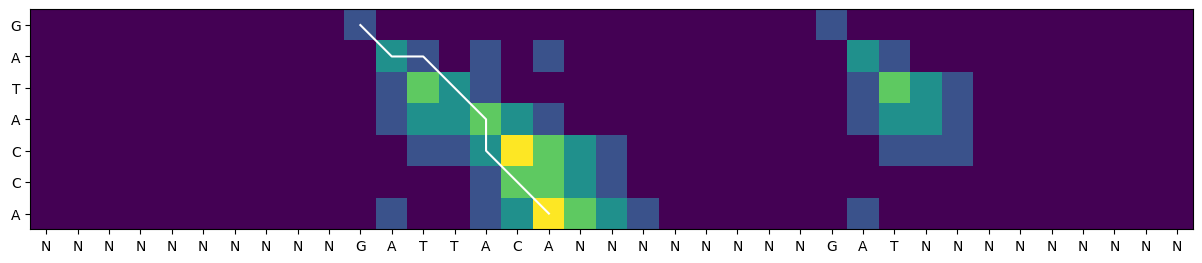

In [11]:
x = "GATACCA"
y = "NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN"

align = aln.make_align(mode="local")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

plt.figure(figsize=[15, 8])
plt.imshow(X=scoring_mat)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(warp_path_y, warp_path_x, "w")
plt.show()

# Read alignment

We can also simulate the alignment of many reads originating from e.g., a bulk DNA sequencing experiment.

First, we simulate the generation of a number of reads, by sampling  5 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [12]:
import random

reference_sequence = "GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA"

n_reads = 20
min_read_len = 15
max_read_len = 25

reads = []

while len(reads) < n_reads:
    range_acquired = False
    while not range_acquired:
        start_position = random.randrange(len(reference_sequence))
        end_position = random.randrange(len(reference_sequence))
        if start_position > end_position:
            continue
        range_len = end_position - start_position + 1
        if range_len < min_read_len or range_len > max_read_len:
            continue
        range_acquired = True
    read = reference_sequence[start_position : (end_position + 1)]
    reads.append(read)

print(reads)

['GATCAAATAGTAAATCCATT', 'TCAAAGCAGTATCGA', 'TCGATCAAATAGTAAATCCA', 'GTATCGATCAAATAGTAAATCC', 'AAAGCAGTATCGATCAA', 'TGTTCAACTCACAGT', 'TTTGTTCAACTCACAGTT', 'TAGTAAATCCATTTGTTCA', 'TTCAAAGCAGTATCGA', 'AGTATCGATCAAATAGTAAAT', 'TTGGGGTTCAAAGCAGTA', 'AATCCATTTGTTCAACT', 'GGGTTCAAAGCAGTATC', 'CCATTTGTTCAACTCACAG', 'AAAGCAGTATCGATCAAATA', 'ATCAAATAGTAAATCC', 'GTAAATCCATTTGTTCAACTCACA', 'TTTGTTCAACTCACAGTTTA', 'AGCAGTATCGATCAA', 'GTTCAAAGCAGTATCGATCAAA']


Next we add some noise to the sampled reads.

In [13]:
def add_noise(read: str, noiselessness: int = 4) -> tuple[str, int]:
    choices = ["A", "C", "G", "T"]
    n_noisy_bases = 0
    noisy_read = ""
    for base in read:
        if not random.randrange(noiselessness):
            noisy_read += random.choice(seq=[c for c in choices if c != base])
            n_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, n_noisy_bases


noisy_reads = []
for read in reads:
    noisy_read, n_noisy_bases = add_noise(read=read, noiselessness=3)
    print(f"Added {n_noisy_bases:2} noisy base(s): {read:10s} -> {noisy_read:10s}")
    noisy_reads.append(noisy_read)

Added  5 noisy base(s): GATCAAATAGTAAATCCATT -> GATAAAATAGCATATTCATG
Added  4 noisy base(s): TCAAAGCAGTATCGA -> TCAACGCGTTCTCGA
Added  7 noisy base(s): TCGATCAAATAGTAAATCCA -> TCCAGGTCATAGTAAGTCCC
Added  8 noisy base(s): GTATCGATCAAATAGTAAATCC -> TTCTCGATACAGTTGCAAACCC
Added  6 noisy base(s): AAAGCAGTATCGATCAA -> AATACAGAATATAACAA
Added  5 noisy base(s): TGTTCAACTCACAGT -> TGTAACGCTCACGGT
Added  8 noisy base(s): TTTGTTCAACTCACAGTT -> TCCGTTAGGCGGTCAGTT
Added  6 noisy base(s): TAGTAAATCCATTTGTTCA -> AGGTAAATTGATTTTTTTA
Added  4 noisy base(s): TTCAAAGCAGTATCGA -> TCCAAAGAAATATCAA
Added  9 noisy base(s): AGTATCGATCAAATAGTAAAT -> AGTTTCGTTCCGGTGCTGATT
Added  5 noisy base(s): TTGGGGTTCAAAGCAGTA -> TTTGGGCTGAAAGGCGTA
Added 11 noisy base(s): AATCCATTTGTTCAACT -> CAAATGATTGACCAGTG
Added  5 noisy base(s): GGGTTCAAAGCAGTATC -> AGGTTCACAGCGGTTGC
Added  8 noisy base(s): CCATTTGTTCAACTCACAG -> GAAACTGTTGGACTAAGAG
Added  7 noisy base(s): AAAGCAGTATCGATCAAATA -> AAAGTATTCTCCGTCAACAA
Added  3 noisy ba

We now align the noisy reads locally to the reference sequence.

Read                      : GATAAAATAGCATATTCATG
Mapping position (0-based): 23
Aligned read              : GATAAAATAGCATATTCAT
Aligned read w/o gaps     : GATAAAATAGCATATTCAT
Number of clipped bases   : 1
Reference subsequence     : GATCAAATAGTAAATCCAT


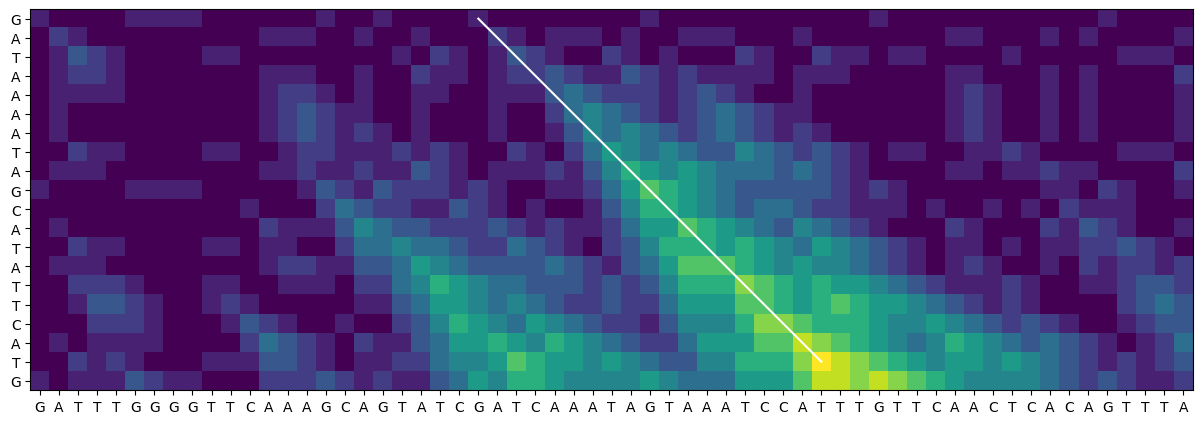

Read                      : TCAACGCGTTCTCGA
Mapping position (0-based): 10
Aligned read              : TCAACGC-GTTCTCGA
Aligned read w/o gaps     : TCAACGCGTTCTCGA
Number of clipped bases   : 0
Reference subsequence     : TCAAAGCAGTATCGA


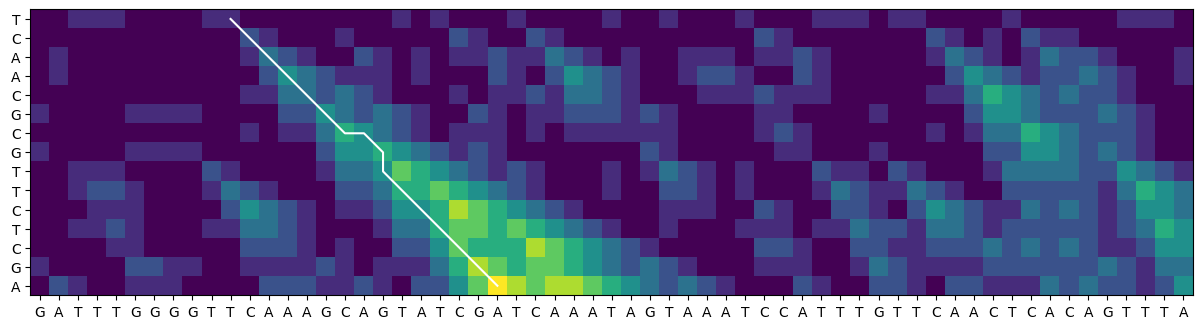

Read                      : TCCAGGTCATAGTAAGTCCC
Mapping position (0-based): 29
Aligned read              : ATAGTAAGTCC
Aligned read w/o gaps     : ATAGTAAGTCC
Number of clipped bases   : 9
Reference subsequence     : ATAGTAAATCC


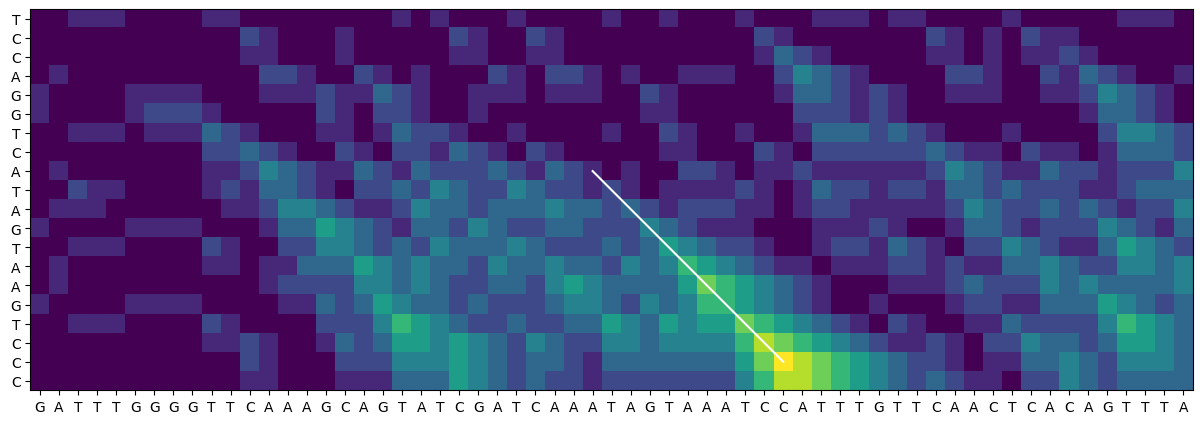

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [21 40]
Read                      : TTCTCGATACAGTTGCAAACCC
Mapping position (0-based): 21
Aligned read              : TCGAT-ACAGTTGCAAA-CC
Aligned read w/o gaps     : TCGATACAGTTGCAAACC
Number of clipped bases   : 4
Reference subsequence     : TCGATCAAATAGTAAATCC


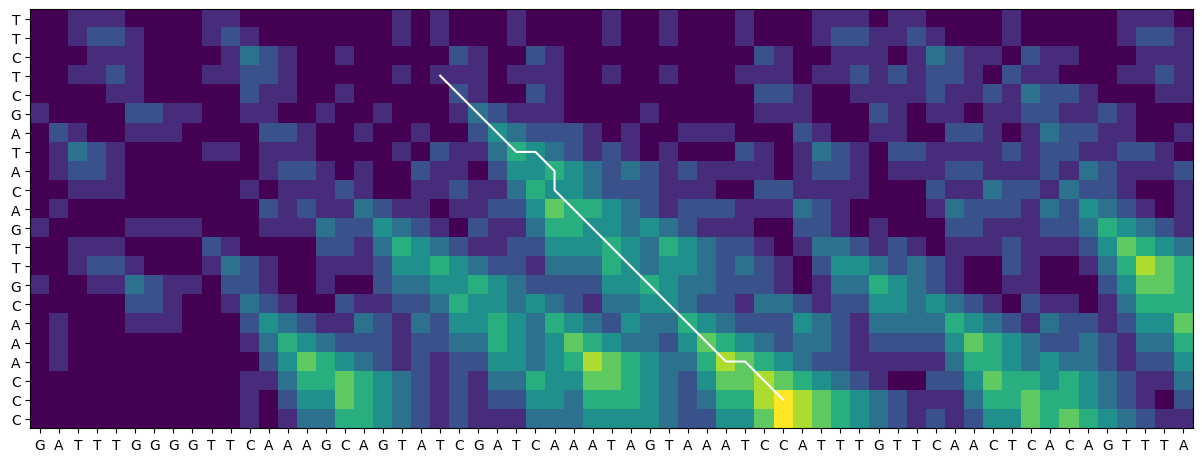

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [14 36]
Read                      : AATACAGAATATAACAA
Mapping position (0-based): 24
Aligned read              : ATACAGAATA-TAA
Aligned read w/o gaps     : ATACAGAATATAA
Number of clipped bases   : 4
Reference subsequence     : ATCAAATAGTAA


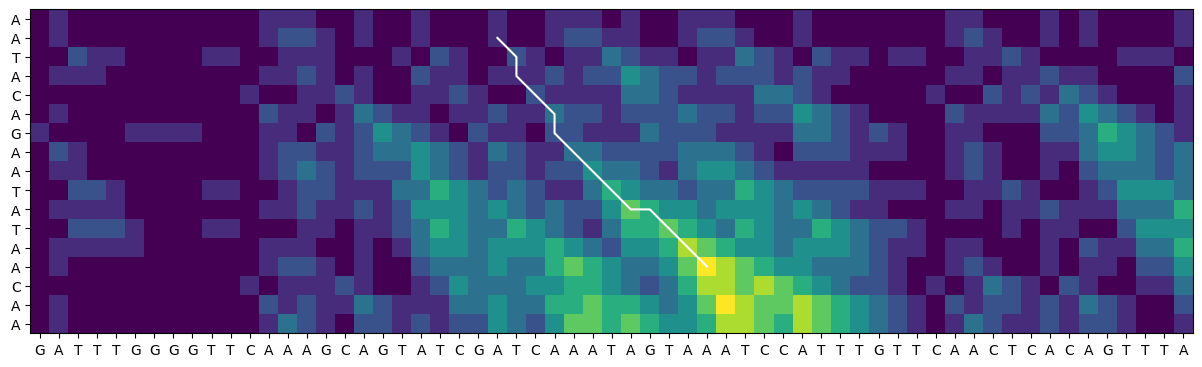

Read                      : TGTAACGCTCACGGT
Mapping position (0-based): 43
Aligned read              : TG-T-AACGCTCACGGT
Aligned read w/o gaps     : TGTAACGCTCACGGT
Number of clipped bases   : 0
Reference subsequence     : TGTTCAACTCACAGT


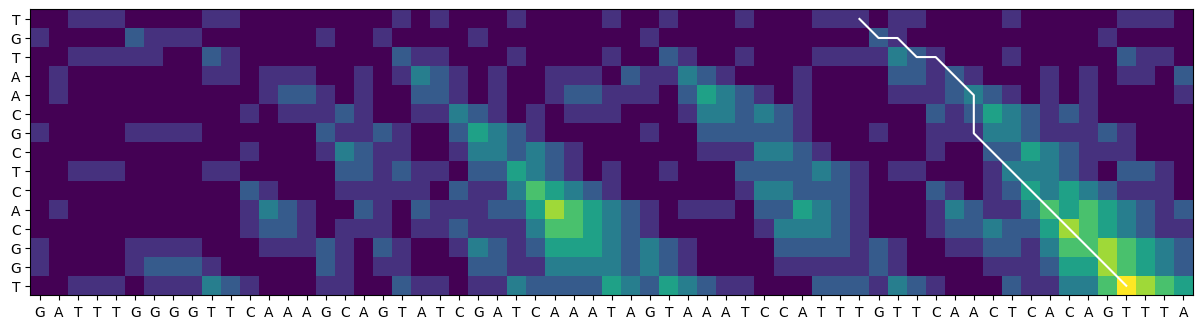

Read                      : TCCGTTAGGCGGTCAGTT
Mapping position (0-based): 2
Aligned read              : TTAGGCGG-TCA
Aligned read w/o gaps     : TTAGGCGGTCA
Number of clipped bases   : 7
Reference subsequence     : TTTGGGGTTCA


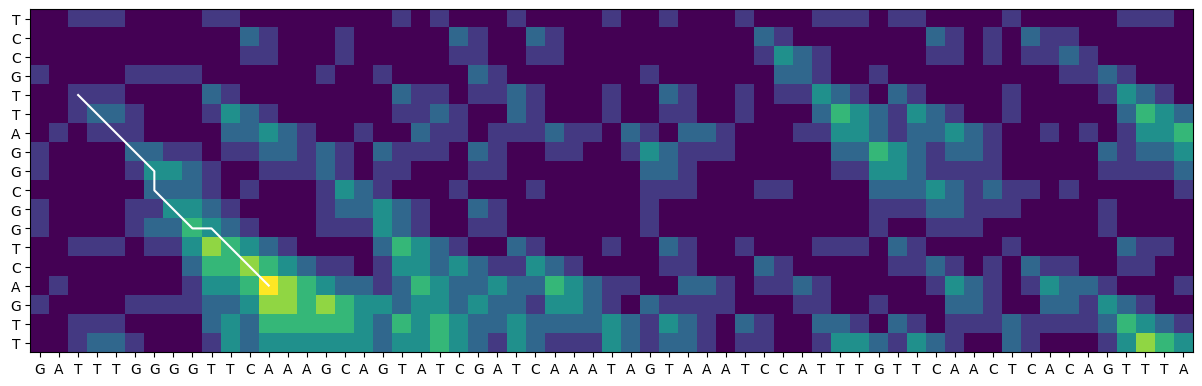

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [16 47]
Read                      : AGGTAAATTGATTTTTTTA
Mapping position (0-based): 32
Aligned read              : GTAAATTGATTT-TT
Aligned read w/o gaps     : GTAAATTGATTTTT
Number of clipped bases   : 5
Reference subsequence     : GTAAATCCATTTGTT


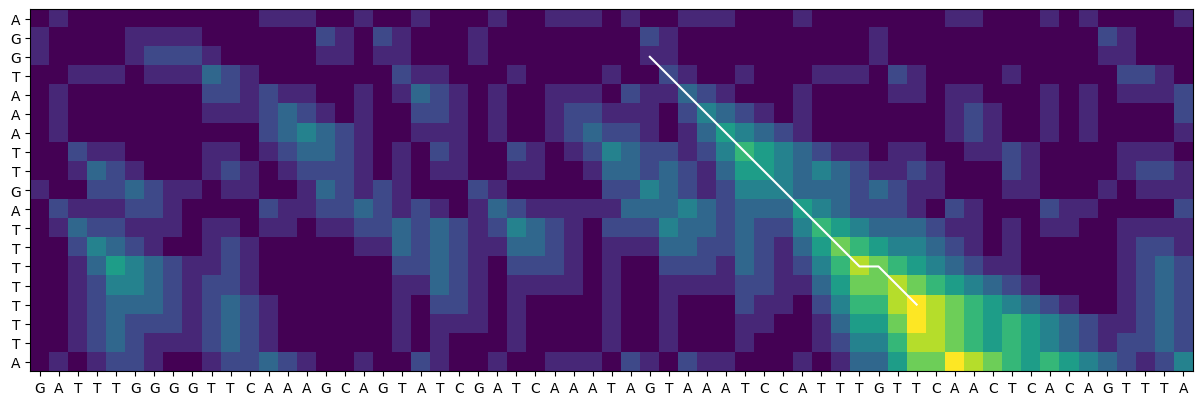

align: Multiple (4) possible traceback starts
align: Choosing traceback start by random: [14 23]
Read                      : TCCAAAGAAATATCAA
Mapping position (0-based): 11
Aligned read              : CAAAGAAATATC
Aligned read w/o gaps     : CAAAGAAATATC
Number of clipped bases   : 4
Reference subsequence     : CAAAGCAGTATC


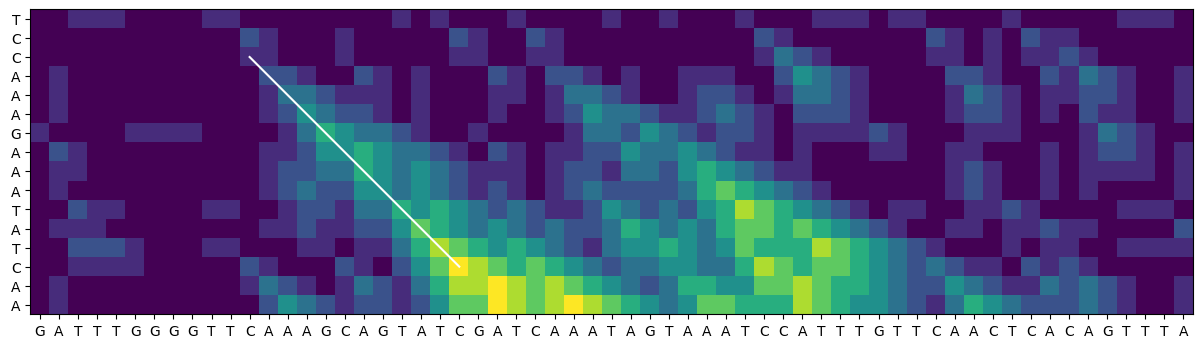

align: Multiple (2) possible traceback starts
align: Choosing traceback start by random: [10 27]
Read                      : AGTTTCGTTCCGGTGCTGATT
Mapping position (0-based): 17
Aligned read              : AGTTTCGTTC
Aligned read w/o gaps     : AGTTTCGTTC
Number of clipped bases   : 11
Reference subsequence     : AGTATCGATC


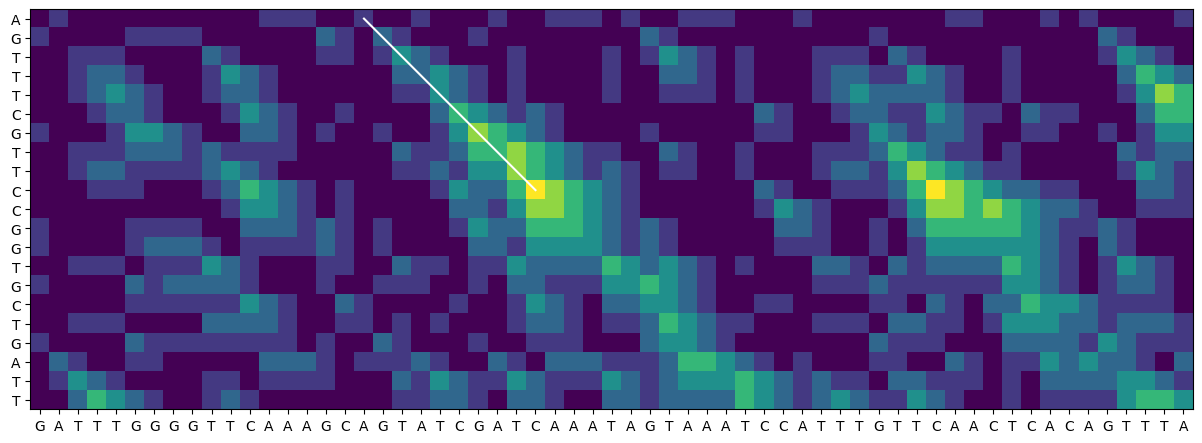

Read                      : TTTGGGCTGAAAGGCGTA
Mapping position (0-based): 2
Aligned read              : TTT-GGGCTGAAAGGC-GTA
Aligned read w/o gaps     : TTTGGGCTGAAAGGCGTA
Number of clipped bases   : 0
Reference subsequence     : TTTGGGGTTCAAAGCAGTA


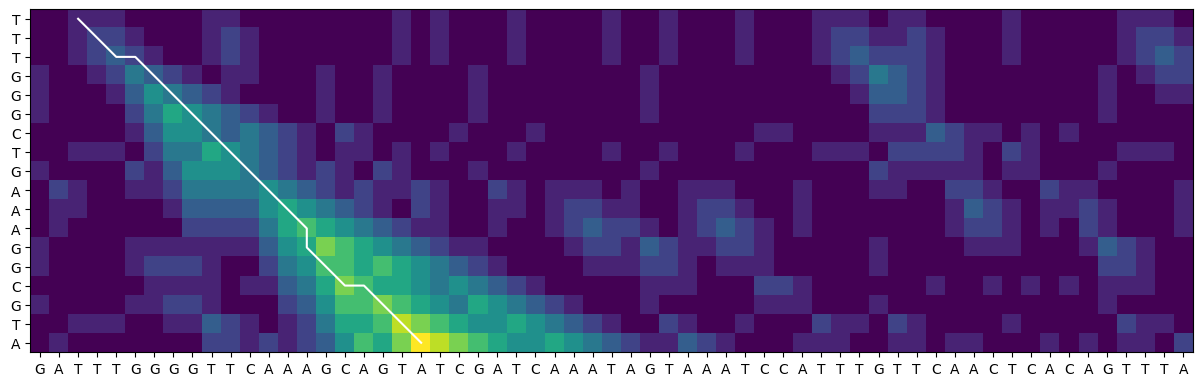

align: Multiple (5) possible traceback starts
align: Choosing traceback start by random: [14 28]
Read                      : CAAATGATTGACCAGTG
Mapping position (0-based): 11
Aligned read              : CAAATG-A-T-T-GACCA
Aligned read w/o gaps     : CAAATGATTGACCA
Number of clipped bases   : 3
Reference subsequence     : CAAAGCAGTATCGATCA


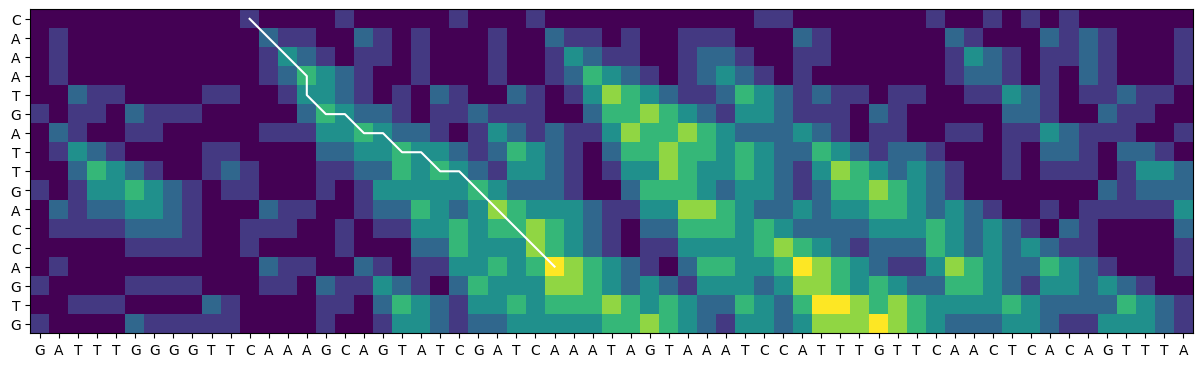

align: Multiple (4) possible traceback starts
align: Choosing traceback start by random: [15 22]
Read                      : AGGTTCACAGCGGTTGC
Mapping position (0-based): 7
Aligned read              : GGTTCACAGCGGT-T
Aligned read w/o gaps     : GGTTCACAGCGGTT
Number of clipped bases   : 3
Reference subsequence     : GGTTCAAAGCAGTAT


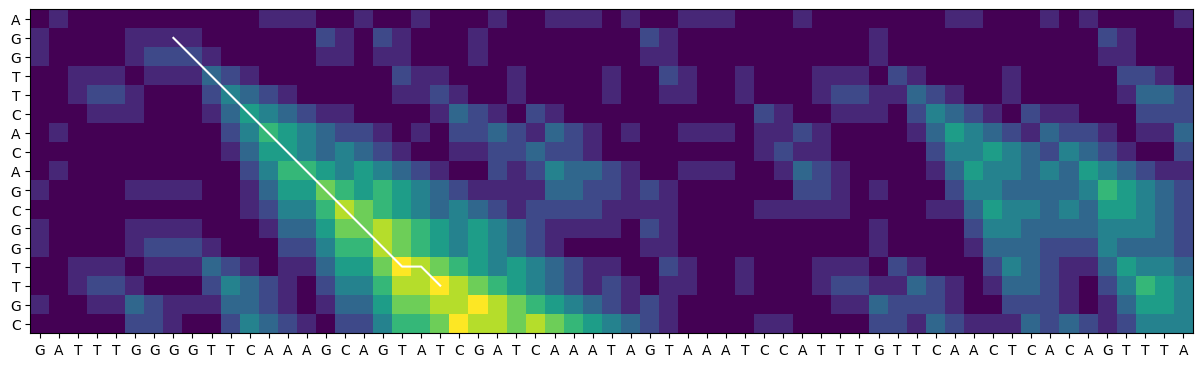

Read                      : GAAACTGTTGGACTAAGAG
Mapping position (0-based): 12
Aligned read              : AAA-CTGT-TGGA-CTAAGAG
Aligned read w/o gaps     : AAACTGTTGGACTAAGAG
Number of clipped bases   : 1
Reference subsequence     : AAAGCAGTATCGATCAAATAG


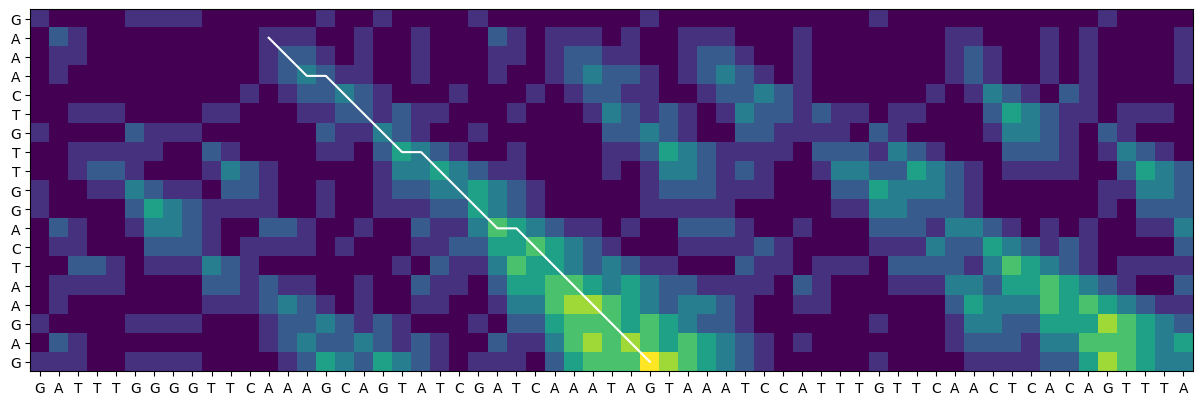

align: Multiple (3) possible traceback starts
align: Choosing traceback start by random: [17 29]
Read                      : AAAGTATTCTCCGTCAACAA
Mapping position (0-based): 12
Aligned read              : AAAGTATTCTCCG-TCAA
Aligned read w/o gaps     : AAAGTATTCTCCGTCAA
Number of clipped bases   : 3
Reference subsequence     : AAAGCAGTATCGATCAA


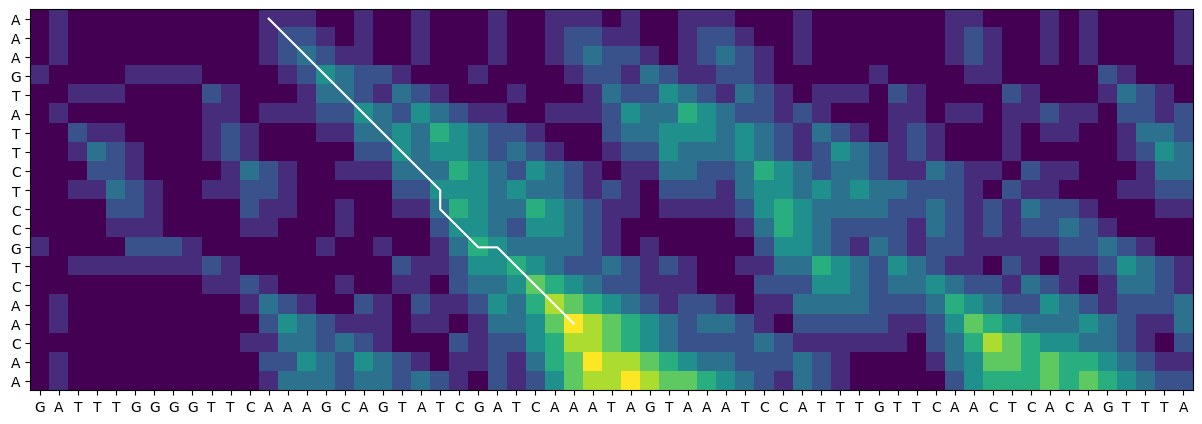

Read                      : ATCAAAAAGAAAAGCC
Mapping position (0-based): 24
Aligned read              : ATCAAAAAGAAAAGCC
Aligned read w/o gaps     : ATCAAAAAGAAAAGCC
Number of clipped bases   : 0
Reference subsequence     : ATCAAATAGTAAATCC


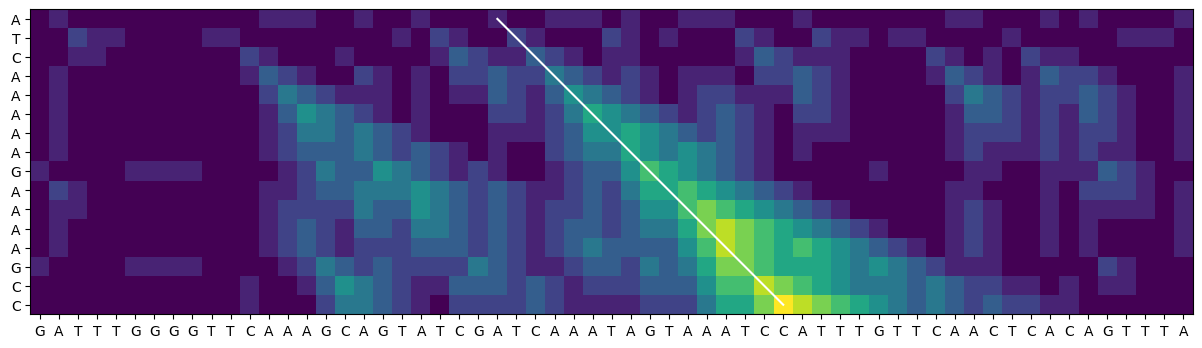

align: Multiple (5) possible traceback starts
align: Choosing traceback start by random: [23 56]
Read                      : TTGGATCCAGTTGTTAATCTGAAC
Mapping position (0-based): 36
Aligned read              : ATCCAGTTGTT-AATCTGA-A
Aligned read w/o gaps     : ATCCAGTTGTTAATCTGAA
Number of clipped bases   : 5
Reference subsequence     : ATCCATTTGTTCAACTCACA


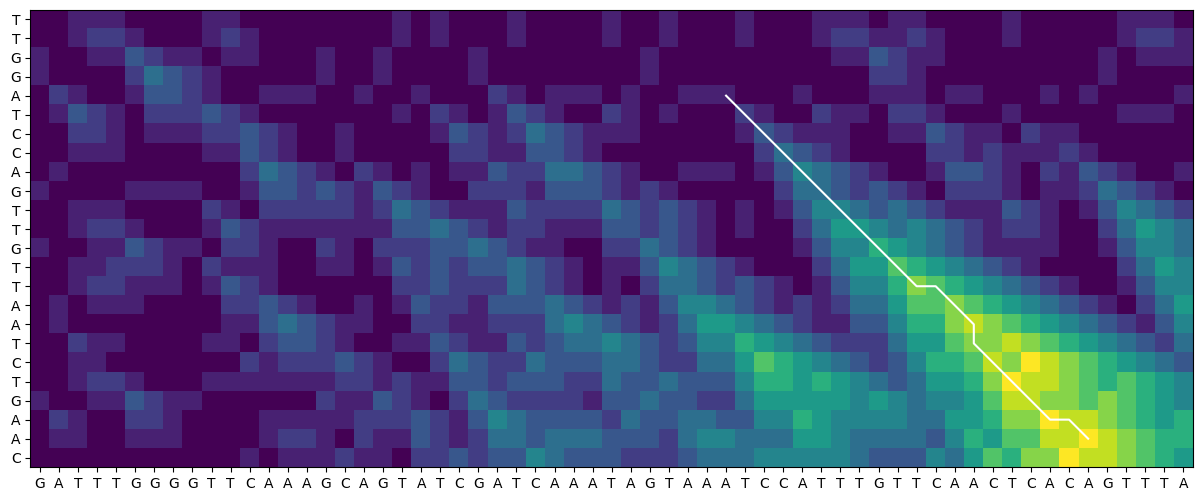

Read                      : TTTTTTCAAGCCACAGTTTT
Mapping position (0-based): 41
Aligned read              : TTTTTTCAAGC-CACAGTTT
Aligned read w/o gaps     : TTTTTTCAAGCCACAGTTT
Number of clipped bases   : 1
Reference subsequence     : TTTGTTCAACTCACAGTTT


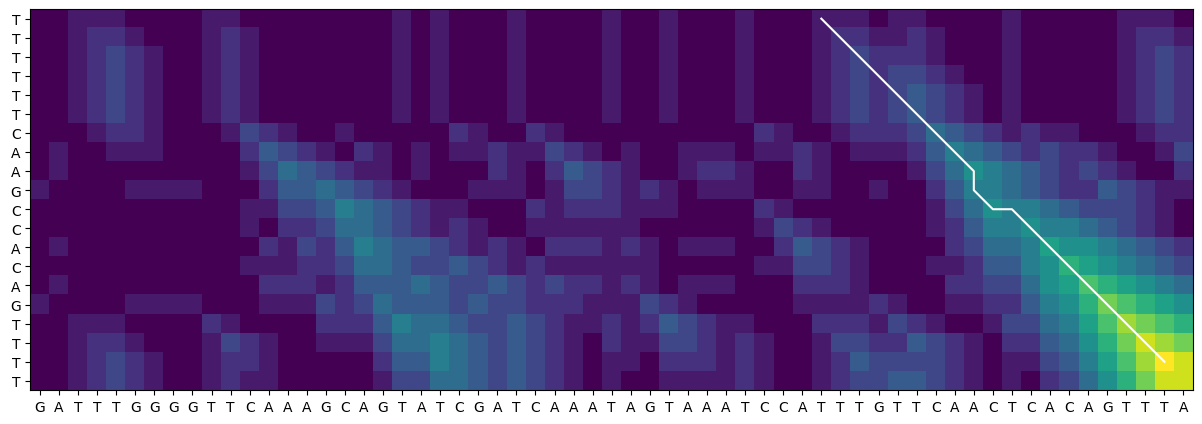

Read                      : AGCAGTACGTATCAA
Mapping position (0-based): 14
Aligned read              : AGCAGTA-CGTATCAA
Aligned read w/o gaps     : AGCAGTACGTATCAA
Number of clipped bases   : 0
Reference subsequence     : AGCAGTATCGATCAA


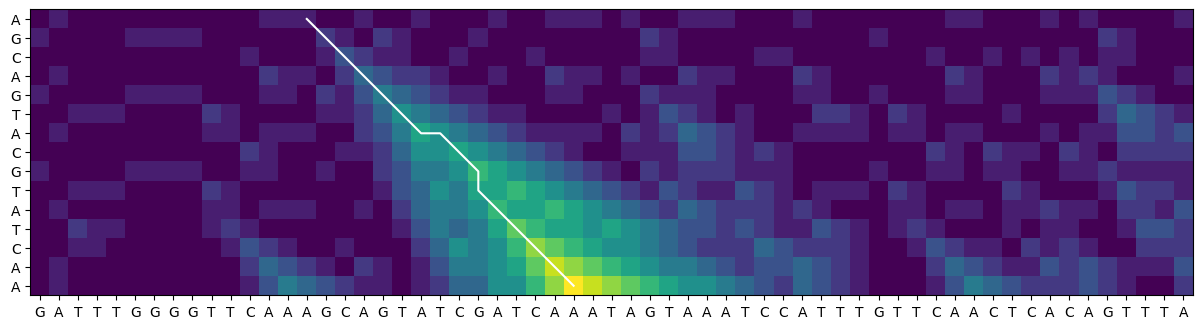

Read                      : GTTCGACGCATTATCGAACAAA
Mapping position (0-based): 8
Aligned read              : GTTCGACGCATTATCGAACAAA
Aligned read w/o gaps     : GTTCGACGCATTATCGAACAAA
Number of clipped bases   : 0
Reference subsequence     : GTTCAAAGCAGTATCGATCAAA


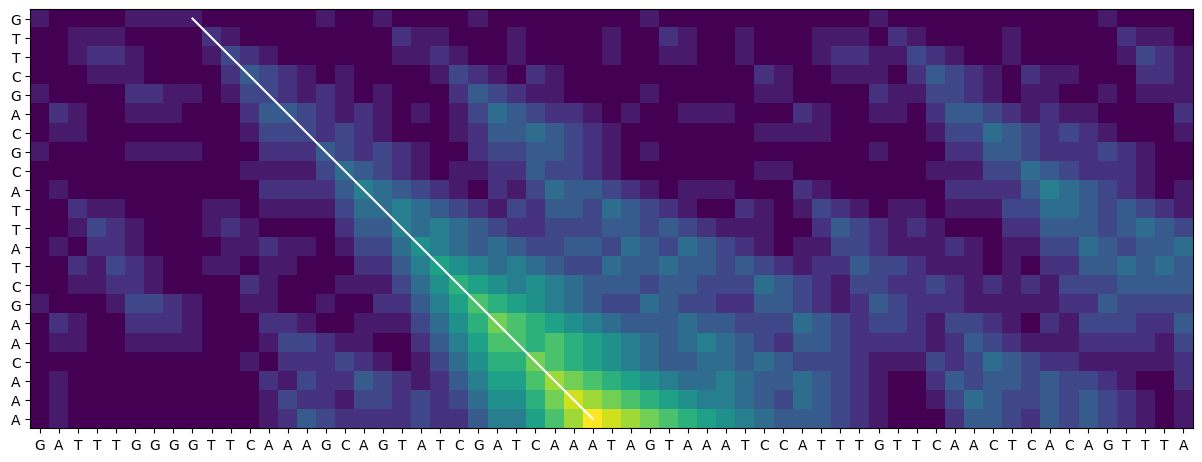

In [14]:
mapping_positions = []
aligned_reads = []

for read in noisy_reads:
    align = aln.make_align(mode="local")
    read_aln, ref_aln, warp_path_read, warp_path_ref, scoring_mat = align(
        seq_a=read, seq_b=reference_sequence
    )

    mapping_position = warp_path_ref[0]
    aligned_read = "".join(read_aln)
    mapping_positions.append(mapping_position)
    aligned_reads.append(aligned_read)

    print(f"Read                      : {read}")
    print(f"Mapping position (0-based): {mapping_position}")
    print(f"Aligned read              : {aligned_read}")
    aligned_read_without_gaps = list(filter(lambda elem: elem != "-", read_aln))
    print(f"Aligned read w/o gaps     : {''.join(aligned_read_without_gaps)}")
    print(f"Number of clipped bases   : {len(read) - len(aligned_read_without_gaps)}")
    print(
        f"Reference subsequence     : {reference_sequence[warp_path_ref[0] : (warp_path_ref[-1] + 1)]}"
    )

    plt.figure(figsize=[15, 8])
    plt.imshow(X=scoring_mat)
    plt.plot(warp_path_ref, warp_path_read, "w")
    plt.xticks(ticks=range(len(reference_sequence)), labels=reference_sequence)
    plt.yticks(ticks=range(len(read)), labels=read)
    plt.show()

We now have the following set of aligned reads:

In [15]:
print(f"Reference: {reference_sequence}")
for i, (pos, seq) in enumerate(zip(mapping_positions, aligned_reads)):
    print(f"Read {i:4}: {' ' * pos}{seq}")

Reference: GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA
Read    0:                        GATAAAATAGCATATTCAT
Read    1:           TCAACGC-GTTCTCGA
Read    2:                              ATAGTAAGTCC
Read    3:                      TCGAT-ACAGTTGCAAA-CC
Read    4:                         ATACAGAATA-TAA
Read    5:                                            TG-T-AACGCTCACGGT
Read    6:   TTAGGCGG-TCA
Read    7:                                 GTAAATTGATTT-TT
Read    8:            CAAAGAAATATC
Read    9:                  AGTTTCGTTC
Read   10:   TTT-GGGCTGAAAGGC-GTA
Read   11:            CAAATG-A-T-T-GACCA
Read   12:        GGTTCACAGCGGT-T
Read   13:             AAA-CTGT-TGGA-CTAAGAG
Read   14:             AAAGTATTCTCCG-TCAA
Read   15:                         ATCAAAAAGAAAAGCC
Read   16:                                     ATCCAGTTGTT-AATCTGA-A
Read   17:                                          TTTTTTCAAGC-CACAGTTT
Read   18:               AGCAGTA-CGTATCAA
Read   19:       

# Variant calling

Variant calling is a crucial step in analyzing DNA sequence data to identify differences or variations in the genetic code of individuals.
This process involves comparing an individual's DNA sequence (in the form of aligned reads) to a reference sequence to pinpoint variations such as single nucleotide polymorphisms (SNPs), insertions, deletions, and structural alterations.

While there exist many sophisticated variant calling algorithms such as [GATK](https://gatk.broadinstitute.org)'s [HaplotypeCaller](https://gatk.broadinstitute.org/hc/en-us/articles/360037225632-HaplotypeCaller), we will here focus on SNPs only and perform a simple majority voting per locus.

In [16]:
from collections import Counter

pileups = [[] for _ in range(len(reference_sequence))]
snps = {}

# Accumulate the pileups
for pos, seq in zip(mapping_positions, aligned_reads):
    for offset, _ in enumerate(seq):
        pileups[pos + offset].append(seq[offset])

# SNP calling via majority voting
print("POS   REF   MAJ   SNP   PILEUP")
for i, pileup in enumerate(pileups):
    majority_base = ""
    snp = "-"

    # Make a pileup string
    pileup = "".join(pileup)

    # We can only call variants for non-empty pileups
    if pileup:
        # Count the occurrences of each character in the pileup
        char_counts = Counter(pileup)
        # Find the most common character
        majority_base, _ = char_counts.most_common(n=1)[0]
    # No variant if the pileup is empty
    else:
        majority_base = "-"

    # Call it if it's a SNP
    if majority_base != "-" and majority_base != reference_sequence[i]:
        snp = majority_base
        snps[i] = snp

    print(f"{i:3}   {reference_sequence[i]:3}   {majority_base:3}   {snp:3}   {pileup}")

POS   REF   MAJ   SNP   PILEUP
  0   G     -     -     
  1   A     -     -     
  2   T     T     -     TT
  3   T     T     -     TT
  4   T     A     A     AT
  5   G     G     -     G-
  6   G     G     -     GG
  7   G     G     -     CGG
  8   G     G     -     GGGG
  9   T     T     -     GCTT
 10   T     T     -     T-TTT
 11   C     C     -     CTCGCCC
 12   A     A     -     ACAAAAAAG
 13   A     A     -     AAAAACAAA
 14   A     A     -     CAAAAAAAC
 15   G     G     -     GGGTG-GGG
 16   C     C     -     CAGGCCTCC
 17   A     A     -     -AAC-GTAAA
 18   G     G     -     GAG-AGGTGT
 19   T     T     -     TTTG-TTTTT
 20   A     T     T     TATTT--CAA
 21   T     T     -     CTTTA-TTT-T
 22   C     C     -     TCCCTGCCC
 23   G     G     -     GCGG-GCGG
 24   A     A     -     AGAATGAGATA
 25   T     T     -     TATTTA--TAA
 26   C     C     -     A-ACCCTCTC
 27   A     A     -     AACCTCACA
 28   A     A     -     ACAAAAAAA
 29   A     A     -     AAAGAAAAA
 30   T     T

In [17]:
# List all SNPs
print("POS   SNP")
for pos, snp in snps.items():
    print(f"{pos:3}   {snp:3}")

POS   SNP
  4   A  
 20   T  
 51   C  
 53   T  
 54   A  
 56   A  
 57   G  
 58   G  
 60   T  
